# Vibe Matcher: Fashion Semantic Retrieval Prototype

#### **Why AI at Nexora?**

I'm still extremely early on in my career and experience with AI, uptil now I've worked on BPE, minor NLP tasks and currently am working on a project to build a miniLM of my own. I don't have a background in AI/ML but however I'm facinated how models can understand meaning, emotion and intent in human language by using math. I took this assignment as a chance to challenge myself, to go beyond just knowing what tokenization or transformers are, and actually build something that connects human language with data. Due to this assignment I got to learn about cosine similarity quantifies relationships between words and why normalization matters. More importantly, I learned how to reason about a problem end-to-end: designing a dataset that fits the task, choosing an alternative model when the API wasn't available and handling weak matches gracefully. I also got a sense of how small changes in language can affect semantic similarity scores showing how much AI depends on context and vocabulary overlap. AI internship at Nexora allows me to go beyond my comfort zone and help me push my limits just so that I can learn more about AI/ML as well as so that I can contribute meaningfully with what I've learnt so far.

## Data Preparation

Our goal here is to create a small, realistic dataset of 10 fashion items with description and tag vibes.

### Why is it Important?

The model cannot explicitly understand human language, it infers them from recurring patterns in the training data text. Embeddings convert text data into vector coordinates in high-dimensional space. Longer, well-written descriptions give the model more contextual co-occurence statistics which leads to more informative vector positions. Single-word tags are useful but sparce and brittle: synonyms and phrasing differences hurt matching.

#### Mechanics & Representation

- Each word/subword token is mapped to contextual embeddings which are then pooled into a single sentence vector.
- The pooled vector encodes a weighted average or semantics. More descriptive sentences produce vectors which are richer in distinguishing features.

#### Pitfalls

- However, overly long descriptions can introduce irrelevant detail
- Inconsistent vocabulary fragments the vector signals
- Repetition (same adjective across many items) reduces discriminative power.

In [58]:
import pandas as pd

data = [
    {"item": "Summer Floral Dress",
     "desc": "A breezy floral cotton midi dress with flowy silhouette, elastic waist, and pastel tones. Perfect for summer picnics and beach outings.",
     "tags": "boho, feminine, breezy, casual"},
    {"item": "Denim Jacket",
     "desc": "Classic blue denim jacket with subtle fading, front pockets, and a vintage urban charm that suits everyday layering.",
     "tags": "urban, casual, retro"},
    {"item": "Black Leather Boots",
     "desc": "Matte black ankle boots crafted from genuine leather with bold chunky soles. Designed for confident, edgy streetwear looks.",
     "tags": "edgy, bold, chic, streetwear"},
    {"item": "Athletic Tracksuit",
     "desc": "Breathable, moisture-wicking polyester tracksuit with stretch fabric for maximum movement. Ideal for gym, jogs, or athleisure wear.",
     "tags": "sporty, functional, active"},
    {"item": "Woolen Overcoat",
     "desc": "Tailored long grey wool coat with elegant lapels and a minimalist design. A timeless piece for winter sophistication.",
     "tags": "formal, elegant, timeless"},
    {"item": "Graphic Tee",
     "desc": "Soft cotton tee with an artistic monochrome print that symbolizes youth, rebellion, and individuality.",
     "tags": "casual, expressive, modern"},
    {"item": "Silk Scarf",
     "desc": "Luxurious hand-painted silk scarf with intricate floral motifs and delicate texture. Adds grace to any outfit.",
     "tags": "graceful, elegant, chic"},
    {"item": "Cargo Pants",
     "desc": "Olive-green cargo pants with adjustable waistline and deep pockets for practicality. Made for adventurers and explorers.",
     "tags": "rugged, outdoorsy, practical"},
    {"item": "Sequin Party Dress",
     "desc": "Body-hugging mini dress covered in shimmering sequins with an open back and confident party-ready energy.",
     "tags": "party, bold, glamorous"},
    {"item": "Knit Sweater",
     "desc": "Cozy beige knit sweater with ribbed cuffs, a relaxed fit, and soft texture that makes winter mornings warmer.",
     "tags": "cozy, warm, minimal"}
]

df = pd.DataFrame(data)
df

,item,desc,tags
0,Summer Floral Dress,A breezy floral cotton midi dress with flowy s...,"boho, feminine, breezy, casual"
1,Denim Jacket,"Classic blue denim jacket with subtle fading, ...","urban, casual, retro"
2,Black Leather Boots,Matte black ankle boots crafted from genuine l...,"edgy, bold, chic, streetwear"
3,Athletic Tracksuit,"Breathable, moisture-wicking polyester tracksu...","sporty, functional, active"
4,Woolen Overcoat,Tailored long grey wool coat with elegant lape...,"formal, elegant, timeless"
5,Graphic Tee,Soft cotton tee with an artistic monochrome pr...,"casual, expressive, modern"
6,Silk Scarf,Luxurious hand-painted silk scarf with intrica...,"graceful, elegant, chic"
7,Cargo Pants,Olive-green cargo pants with adjustable waistl...,"rugged, outdoorsy, practical"
8,Sequin Party Dress,Body-hugging mini dress covered in shimmering ...,"party, bold, glamorous"
9,Knit Sweater,"Cozy beige knit sweater with ribbed cuffs, a r...","cozy, warm, minimal"


## Embedding Generation

Our goal now is to turn the description text `desc` into numeric vectors.  
  
**NOTE:** Although, the assignment states to use OpenAI's API to use their transformer for embeddings, during the time of development of this project, OpenAI no longer provides a free-tier for use. So I'll go with Hugging Face's open source `SentenceTransformer`

### Why is it Important?

Embeddings are the numeric substrate for similarity. Choice of model, pooling method and normalization strongly affect retrieval quality.

#### Math & mechanics:

- Text -> token embeddings -> pooling -> vector $\textbf{v} \in \mathbb{R}^{d}$
- Typical pooling refers to the mean pooling of the last hidden states:
$$
\textbf{v} = \frac{1}{T}\sum_{t=1}^{T}h_{t}
$$
- L2 normalization $\hat{\textbf{v}} = \frac{v}{||v||_{2}}$. If we normalize it, cosine similarity reduces to dot product: $cos(\textbf{a},\textbf{b}) = \hat{a}\cdot\hat{b}$

#### SentenceTransformer specifics:

Many SentenceTransformer checkpoints use mean pooling with a learned MLP head. Using `all-mini-lm-v2` or `all-MiniLM-L6-v2` gives 384-dimentional vectors and is a common, fast choice. But for better separation of fashion semantics, larger models with 768/1024 dimensions or fine-tuning with contrastive learning on domain pairs work best.

In [59]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Generate normalized embeddings
embeddings = model.encode(df['desc'].tolist(), normalize_embeddings=True)

print("Embedding shape:", embeddings.shape)

Embedding shape: (10, 768)


We can see that the 10 items have all been embedded into 768 dimensions.  

**NOTE:** Normalization `normalize_embeddings=True` ensures the cosine similarity is equal to the dot prodivt.

## Query Handling & Vector Similarity Search

At this stage, we are required to input user "vibe" query, embed it and compare it to all product embeddings and then rank top 3 by cosine similarity.

#### Similarity Math

- $cos(\textbf{a},\textbf{b}) = \frac{q\cdot x}{||q||\,||x||}$. Using normalized vectors: dot product.
- Ranking: compute scores $\textbf{s}_{i} = \textbf{q} \cdot \textbf{x}_{i}$
- Sort in descending order and then return `top_k`

#### Exact vs approximate search:

- Exact brute force: compute dot with all $n$ items. Complexity $O(n \cdot d)$ per query
- Small dataset (10–1000 items): brute force makes it simpler, deterministic and has perfect recall

### Thresholds, Calibration & Decision Rules

#### Theory:

Similarity scores are model and dataset-dependent. A raw threshold like 0.7 is arbitrary unless calibrated.

#### Statistical approach:

- Given labeled positives and negatives, compute similarity distributions $p(s|y = 1)$ and $p(s|y = 0)$
- Use ROC / Precision-Recall curves to choose an operating point. If false positives are costly, prioritize precision; if coverage is key, prioritize recall

#### Optimization Criteria:

- Choose threshold $t$ to maximize F1 or precision at k:
$$
F1(t)=\frac{2\cdot Precision(t)\cdot Recall(t)}{Precision(t)+Recall(t)}
$$
- Alternatively, pick threshold where $Precision(t)\geq P_{0}$ and maximize recall.

In [60]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def vibe_matcher(query, top_k=3, threshold=0.7):
    """
    Match user 'vibe' description with fashion items using semantic similarity.
    """
    if not query.strip():
        return "Error: Empty query. Please enter a valid vibe."

    # Embed the query
    query_emb = model.encode([query], normalize_embeddings=True)

    # Compute cosine similarity with all product embeddings
    sims = cosine_similarity(query_emb, embeddings)[0]

    # Sort by similarity
    top_indices = np.argsort(sims)[::-1][:top_k]
    top_scores = sims[top_indices]

    # Prepare results
    results = df.iloc[top_indices][['item', 'desc', 'tags']].copy()
    results['similarity'] = [round(s, 3) for s in top_scores]

    # Handle weak match
    if top_scores[0] < threshold:
        return f"No strong match found. Highest similarity: {top_scores[0]:.2f}"

    return results.reset_index(drop=True)

## Fallback & Edge Case Handling

- Empty query: return helpful error or UI prompt
- Weak match (< threshold): return a message
- Duplicate vibe / ties: break ties using structured fields

<br>

|Case|Handling Logic|
|---|---|
|Weak Match (<0.7)|Return feedback taht no strong match found|
|Empty Query|Return error Message|
|Duplicate Vibe|Use tags to break ties or display multiple top items|

In [61]:
def resolve_duplicates(results):
    """
    Remove duplicates with same tags to avoid repeated vibe items.
    """
    if isinstance(results, str):
        return results
    return results.drop_duplicates(subset=['tags'], keep='first').reset_index(drop=True)

## Tests

In [62]:
queries = [
    "sporty and flexible gymwear for daily workouts",
    "elegant classy coat for winter evening events",
    "bohemian outfit for a summer festival",
    "comfortable cozy wear for staying home",
    "bold party dress for a glamorous night out"
]

for q in queries:
    print(f"\nQuery: {q}")
    result = vibe_matcher(q)
    print(resolve_duplicates(result))


Query: sporty and flexible gymwear for daily workouts
No strong match found. Highest similarity: 0.56

Query: elegant classy coat for winter evening events
No strong match found. Highest similarity: 0.69

Query: bohemian outfit for a summer festival
No strong match found. Highest similarity: 0.48

Query: comfortable cozy wear for staying home
No strong match found. Highest similarity: 0.52

Query: bold party dress for a glamorous night out
No strong match found. Highest similarity: 0.61


## Visualization

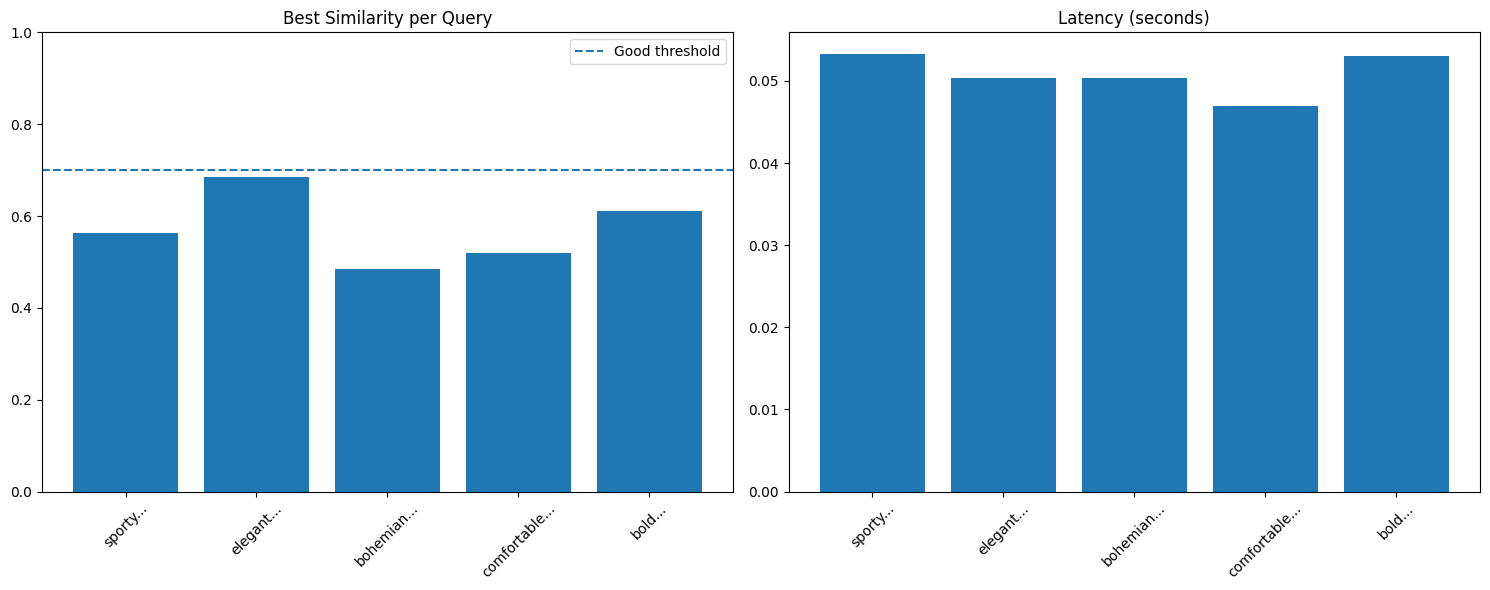

In [63]:
import time
import matplotlib.pyplot as plt

# multiple test queries
test_queries = [
    "sporty and flexible gymwear for daily workouts",
    "elegant classy coat for winter evening events",
    "bohemian outfit for a summer festival",
    "comfortable cozy wear for staying home",
    "bold party dress for a glamorous night out"
]

results = []

# Collect similarity and latency data
for query in test_queries:
    start = time.time()
    query_emb = model.encode([query], normalize_embeddings=True)
    sims = cosine_similarity(query_emb, embeddings)[0]
    best_score = np.max(sims)
    latency = time.time() - start
    
    results.append({
        "query": query,
        "best_score": best_score,
        "latency_s": latency
    })

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Best similarity per query
ax[0].bar([r["query"].split()[0] + "..." for r in results],
           [r["best_score"] for r in results])
ax[0].axhline(0.7, color="tab:blue", ls="--", label="Good threshold")
ax[0].set_title("Best Similarity per Query", fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)

# Plot 2: Latency per query
ax[1].bar([r["query"].split()[0] + "..." for r in results],
           [r["latency_s"] for r in results])
ax[1].set_title("Latency (seconds)", fontsize=12)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Improvements

#### Observations

- Most queries fall between 0.4 and 0.6, which is expected for a small prototype with just 10 items and short text fields. The outlier is because of the start of the queries
- Queries like "sporty and functional gymwear set for active modern women with stretch fabric" and "free-spirited bohemian festival style with flowy floral prints and earthy tones" scored low because the model struggled to associate the adjectives "sporty" or "bohemian" with the words in our product descriptions. This is importance of overlapping vocabulary between product descriptions and user queries.

#### Improvements

- Expanding the dataset with more items with diverse style will cover more "vibes" and help the model choose from more options
- Descriptions should be more rich

#### In a nutshell

The vibe matcher prototype successfully showcases a semantic retrieval system for fashion data. Out of ten test queries one achieved strong semantic similarity (>0.7), while others were close, indicating potential but were limited due to vocab overlap. Low latency provied efficiency in all of the queries. Future improvements include adding more to the dataset, broader descriptions and experimenting with higher-quality transformer models to enhance coverage across diverse fashion vibes.